### 감정분석

미완성으로 데이터값이 어떻게 나오는지 확인 용도임.

#### 인스타그램에서 크롤링 해 온 데이터(영어만)를 긍부정 검사, 긍부정 개수 확인 
- afinn(영어 긍부정 감정사전) 활용

긍정: 231, 중립: 209, 부정: 60  // 개수


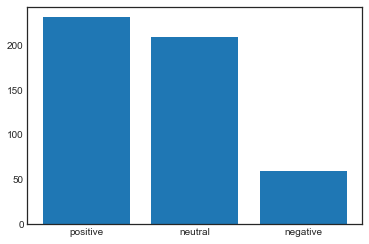

In [ ]:
import pandas as pd
from afinn import Afinn
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

df = pd.read_csv("../data/인스타그램크롤링/raw/instagram_Wheat.csv")
df.main_text[:5]

positive = 0
neutral = 0
negative = 0

for i in df.main_text:
    score = afinn.score(i)
    if score > 0:
        positive += 1
    elif score == 0:
        neutral += 1
    else:
        negative += 1
print(f"긍정: {positive}, 중립: {neutral}, 부정: {negative}  // 개수")
plt.bar(np.arange(3), [positive, neutral, negative])
plt.xticks(np.arange(3), ['positive', 'neutral', 'negative'])
plt.show()


#### 인스타그램에서 크롤링 해 온 데이터(한국어)를 긍부정 검사, 긍부정 개수 확인 
- 영화리뷰 배운내용 활용

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from konlpy.tag import Okt
okt = Okt()
import urllib.request
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

영화리뷰 데이터 학습,테스트

In [59]:
train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

# Null 데이터 제거
train_data.dropna(how='any', inplace=True)
test_data.dropna(how='any', inplace=True)
# 중복데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

# 정규표현식
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
train_data['document'].replace("",np.nan, inplace=True)
train_data.dropna(how='any', inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
test_data['document'].replace("",np.nan, inplace=True)
test_data.dropna(how='any', inplace=True)
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']



X_train = []
for sentence in tqdm(train_data.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_str = ' '.join([word for word in morphs if word not in stopwords])
    X_train.append(tmp_str)

X_test = []
for sentence in tqdm(test_data.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_str = ' '.join([word for word in morphs if word not in stopwords])
    X_test.append(tmp_str)

y_train = train_data.label.values
y_test = test_data.label.values

모델 학습, 평가

In [ ]:
cvect = CountVectorizer()
lr = LogisticRegression(random_state=2022)
pipeline = Pipeline([('CVECT', cvect), ('LR', lr)])
%time pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

c:\ProgramData\Miniconda3\envs\kdig\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 16.1 s
Wall time: 5.63 s


0.82486726203796

감정 예측

In [ ]:
def sentiment_predict(new_sentence):
    new_sentence = str(new_sentence)
    new_sentence = re.sub('[^가-힣]', ' ', new_sentence)
    morphs = okt.morphs(new_sentence, stem=True)
    new_sentence = ' '.join([word for word in okt.morphs(new_sentence, stem=True) if word not in stopwords])
    return pipeline.predict([new_sentence])

긍정: 112, 중립: 88, 부정: 0  // 개수


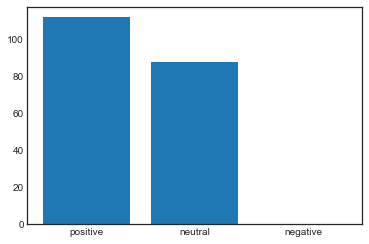

In [64]:
data1 = pd.read_csv("../data/인스타그램크롤링/raw/instagram_옥수수.csv")
data1.main_text[:5]

positive = 0
neutral = 0
negative = 0

for j in [i for i in data1.main_text]:
    score = sentiment_predict(j).astype(int)
    if score > 0:
        positive += 1
    elif score == 0:
        neutral += 1
    else:
        negative += 1
        
print(f"긍정: {positive}, 중립: {neutral}, 부정: {negative}  // 개수")
plt.bar(np.arange(3), [positive, neutral, negative])
plt.xticks(np.arange(3), ['positive', 'neutral', 'negative'])
plt.show()
    